In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import sys

from seqm.seqm_functions.constants import Constants
from seqm.basics import Energy

In [2]:
#check code to produce energy terms for each molecule
# with a 'learned' given parameters


torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

N = 100
at = 0
#dir = torch.tensor([1.0,0.0,1.0],dtype=dtype,device=device)
#dir=torch.randn(3,dtype=dtype,device=device)
#dir /= torch.norm(dir)
#print(dir.tolist())
dir = torch.tensor([-0.3651281073742882, -0.5962853405673783, 0.7149302468281195],device=device)
dxmin = -0.5
dxmax = 0.5

N += 1
dx = torch.arange(N+0.0,device=device)*(dxmax-dxmin)/(N-1.0)+dxmin

const = Constants().to(device)

species = torch.as_tensor([[8,6,1,1]],dtype=torch.int64, device=device) \
               .expand(N,4)

coordinates_op = torch.tensor([
             [
              [0.014497983896917479, 3.208059775069048e-05, -1.0697192017402962e-07],
              [1.3364260303072648, -3.2628339194439124e-05, 8.51016890853131e-07],
              [1.757659914731728, 1.03950803854101, -5.348699815983099e-07],
              [1.7575581407994696, -1.039614529391432, 2.84735846426227e-06]
             ],
             ], device=device)
#
coordinates = coordinates_op.expand(N,4,3).clone()
coordinates[...,at,:] += dx.unsqueeze(1)*dir.unsqueeze(0)
coordinates.requires_grad_(True)

#"""
#f=open('setup.xyz','w')
#for mol in range(N):
#    f.write("%d\n\n" % torch.sum(species[mol]>0))
#    for atom in range(coordinates.shape[1]):
#        if species[mol,atom]>0:
#            f.write("%s %f %f %f\n" % (const.label[species[mol,atom].item()],
#                                   coordinates[mol,atom,0],
#                                   coordinates[mol,atom,1],
#                                   coordinates[mol,atom,2]))
#
#f.close()
#"""

#np.save('test-R.npy', coordinates.detach().cpu().numpy())
#np.save('test-Z.npy', species.detach().cpu().numpy())

elements = [0]+sorted(set(species.reshape(-1).tolist()))
seqm_parameters = {
                   'method' : 'PM3',  # AM1, MNDO, PM#
                   'scf_eps' : 1.0e-6,  # unit eV, change of electric energy, as nuclear energy doesnt' change during SCF
                   'scf_converger' : [2,0.0], # converger used for scf loop
                                         # [0, 0.1], [0, alpha] constant mixing, P = alpha*P + (1.0-alpha)*Pnew
                                         # [1], adaptive mixing
                                         # [2], adaptive mixing, then pulay
                   'sp2' : [True, 1.0e-5],  # whether to use sp2 algorithm in scf loop,
                                            #[True, eps] or [False], eps for SP2 conve criteria
                   'elements' : elements, #[0,1,6,8],
                   'learned' : [], # learned parameters name list, e.g ['U_ss']
                   #'parameter_file_dir' : '../../seqm/params/', # file directory for other required parameters
                   'pair_outer_cutoff' : 1.0e10, # consistent with the unit on coordinates
                   }


import time
t0 = time.time()
with torch.autograd.set_detect_anomaly(True):
    eng = Energy(seqm_parameters).to(device)
    Hf, Etot, Eelec, Enuc, Eiso, EnucAB, e, P, charge, notconverged = eng(const, coordinates, species, learned_parameters=dict(), all_terms=True)
    L=Etot.sum()
    L.backward()
t1 = time.time()
print('Time : %f sec' % (t1-t0))
#print(Etot)
#print(coordinates.grad)
force = -coordinates.grad
#f=open('log.dat', 'w')
#f.write("#index, dx (Angstrom), energy (eV), force(eV/Angstrom)\n")
#for i in range(N):
#    f.write("%d %12.8e %12.8e %12.8e\n" % (i,dx[i],Etot[i],(force[i,at,:]*dir).sum() ))
#f.close()

Time : 7.856040 sec


-0.25
-0.25


Text(0.5, 1.0, 'Force')

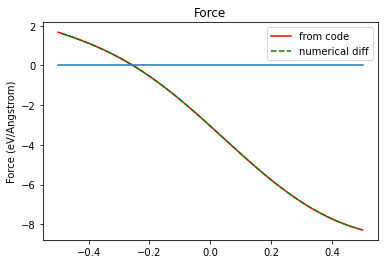

In [3]:
d = np.array([np.arange(0,101,1),dx.detach().cpu().numpy(),Etot.detach().cpu().numpy(),torch.sum((force[:,at,:]*dir),axis=1).detach().cpu().numpy()]).T
#d=np.loadtxt(fn)
##index, distance, energy, force

t=np.argmin(d[:,2])
print(d[t,1])


t=np.argmin(np.abs(d[:,3]))
print(d[t,1])

#-0.122

dx = d[1,1]-d[0,1]

x1 = d[1:-1,1]
f1 = -(d[2:,2]-d[:-2,2])/dx/2.0
plt.figure(0)
plt.plot(d[:,1],d[:,3],'r',label='from code')
plt.plot(x1,f1,'g--', label='numerical diff')
plt.plot(d[:,1], np.zeros_like(d[:,1]))
plt.legend()
plt.ylabel('Force (eV/Angstrom)')
plt.title("Force")
#plt.savefig("force.jpg")
#plt.xlim([0.0,10])

Text(0.5, 1.0, 'Force difference')

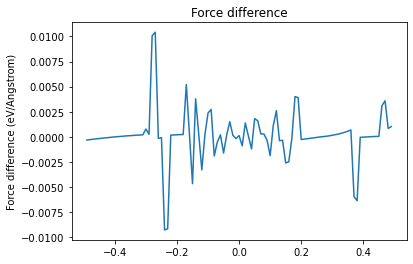

In [4]:
plt.figure(1)
df = d[1:-1,3]-f1
plt.plot(x1[:],df[:])
plt.ylabel('Force difference (eV/Angstrom)')
plt.title("Force difference")
#plt.savefig("dF.jpg")
#plt.xlim([0.0,10])

Text(0.5, 1.0, 'Energy')

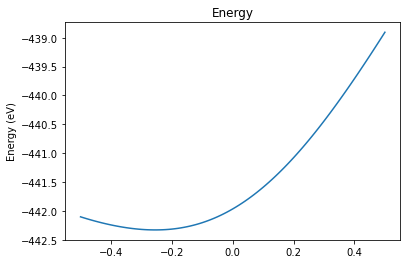

In [5]:
plt.figure(2)
plt.plot(d[:,1], d[:,2])
plt.ylabel('Energy (eV)')
plt.title('Energy')
#plt.savefig("energy.jpg")
#plt.xlim([0.0,10])